# Tonotopic organization of human auditory cortex
https://www.sciencedirect.com/science/article/pii/S0378595513001871

Melissa Saenza  Dave R.M.Langers
also see

C. Humphries, E. Liebenthal, J. Binder
Published 15 April 2010 
NeuroImage

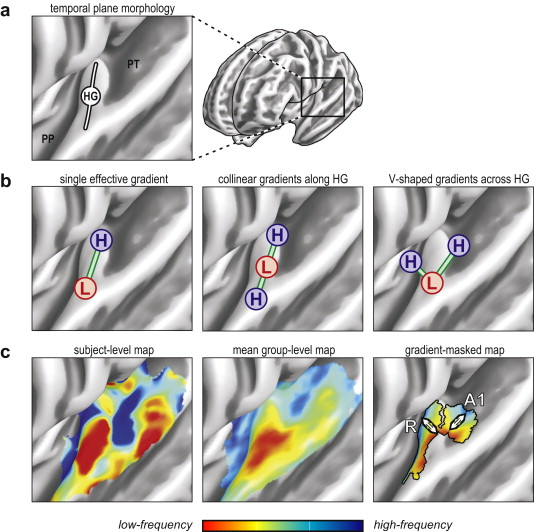

In [1]:
# pip install scipy submitit librosa h5io

In [2]:
from h5io import write_hdf5, read_hdf5
import matplotlib.pyplot as plt
from nibabel.freesurfer.io import read_geometry
from nibabel.freesurfer.io import read_morph_data
from nilearn import plotting
import numpy as np
from scipy.io import wavfile
from submitit import AutoExecutor
import torch
from tqdm.notebook import tqdm
from pathlib import Path
import librosa
import soundfile as sf

from nistats import hemodynamic_models
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold

from brainscore import paths as PATHS
from brainscore.brain.plotting import plot_brain_map_stats
from brainscore.deep_net.data_speech import get_speech_activations
from brainscore.get_brain_score_speech import get_brain_score_speech, get_mean_bold

/private/home/jeanremi/.conda/envs/wav2vec/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: 

 | Using Nistats with Nilearn versions >= 0.7.0 is redundant and potentially conflicting.
 | Nilearn versions 0.7.0 and up offer all the functionality of Nistats as well the latest features and fixes.
 | We strongly recommend uninstalling Nistats and using Nilearn's stats & reporting modules.

  from ipykernel import kernelapp as app


In [3]:
def correlate(X, Y):
    """n-way pearson correlation"""
    if X.ndim == 1:
        X = X[:, None]
    if Y.ndim == 1:
        Y = Y[:, None]
    out = np.zeros(max([Y.shape[1], X.shape[1]]))
    X = X - X.mean(0)
    Y = Y - Y.mean(0)

    SX2 = (X ** 2).sum(0) ** 0.5
    SY2 = (Y ** 2).sum(0) ** 0.5
    SXY = (X * Y).sum(0)
    valid = (SX2 != 0) & (SY2 != 0)
    out[valid] = SXY[valid] / (SX2[valid] * SY2[valid])
    return out


def get_mesh(alpha=.5, hemi='lh'):
    """make brain mesh in between pial and inflated for readbility"""
    infl, faces = read_geometry(str(PATHS.surf_dir / f"{hemi}.inflated"))
    pial, faces = read_geometry(str(PATHS.surf_dir / f"{hemi}.pial"))
    pial, faces = read_geometry(str(PATHS.surf_dir / f"{hemi}.white"))
    morph = infl*alpha+pial*(1-alpha)
    return morph, faces

def get_background(lim=30):
    """binarize gyri/sulci background color"""
    bkg = read_morph_data(PATHS.surf_dir/'lh.avg_curv')
    bkg = ((bkg>np.percentile(bkg, lim))-.5)*bkg.ptp()
    bkg[0] = -1.
    bkg[1] = 1.
    return bkg

# check brain scores on average brain

In [4]:
# check Charlotte Narrative pipeline
tasks = ["pieman"]  # example of story

embed_files = {}
for task in tasks:
    embed_files[task] = PATHS.speech_embeddings / "minimal" / f"{task}_tr.pth"

score = get_brain_score_speech(
    embed_files,
    subject='avg',
    # X
    layers=(8,),  # selected embedding layers
    concat_layers=False,  # whether to concatenate layers of run for each layer
    x_pca=False,  # whether to apply pca on embeddings
    # Y
    rois=False,  # whether to compute scores on brain ROIS
    hemi='L',
    y_pca=False,
    select_tasks=tasks,  # None or subselected selected audio tasks
    # Model
    metric="correlate",
    n_folds=5,
    average_folds=True,
)

Using average subject
Loading BOLD ...
Done
Processing task pieman
Shapes after concatenation 	 deep net: (1, 300, 768) 	 brain: (300, 40962)
Running for layer 8
X.shape (300, 768)
.....

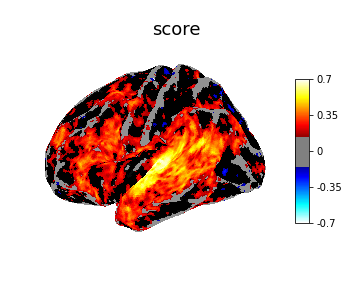

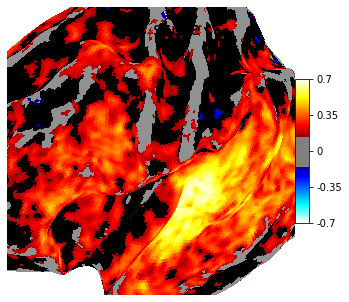

In [5]:
# plot score
for repeat in range(2):
    im = plotting.plot_surf_stat_map(
        surf_mesh=get_mesh(.5),
        stat_map=score[0],
        hemi='left',
        view='lateral',
        vmax=.7,
        cmap='cold_hot',
        symmetric_cbar=True,
        threshold=.15,
        colorbar=True,
        title='score',
        bg_map=get_background(),
        darkness=2,
    )

ax = im.get_axes()[0]
ax.view_init(elev=10., azim=-210)
ax.dist = 4

# Fit GLM on real fmri response to story

In [6]:
bolds = get_mean_bold(hemi='L')

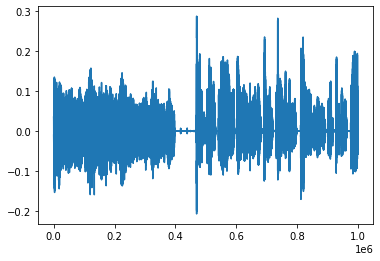

In [7]:
task = 'pieman'
task = 'tunnel'
task = '21styear'
wav, sr = librosa.load(PATHS.stimuli/f'{task}_audio.wav')
plt.plot(wav[:int(1e6)])

In [9]:
def get_mel(wav, sr):
    spec = librosa.feature.melspectrogram(y=wav,
                                          sr=sr,
                                          n_fft=2048*4, 
                                          hop_length=512,
                                          win_length=None,
                                          window='hann', 
                                          center=True, 
                                          pad_mode='reflect', 
                                          power=2.0,
                                          n_mels=128)
    spec = np.log10(spec)
    
    spec = np.clip((spec+4) / 7, 0, 1)
    return spec

In [ ]:
spec = get_mel(wav, sr)

In [ ]:
plt.matshow(spec[:, :2000], aspect='auto', origin='lower')
plt.colorbar()

In [ ]:
def get_features(wav, sr):

    # compute mel spectrogram
    spec = get_mel(wav, sr)
    
    # add audio volume
    volume = spec.mean(0, keepdims=True)
    
    # features
    features = np.r_[spec, volume]
    
    # convolve with hrf
    TR = 1.5
    duration = len(wav)/sr
    event_duration = duration / len(spec.T)
    frame_times = np.arange(0, duration, TR)
    # frame_times = np.cumsum(np.ones(len(bold))) * TR  #FIXME CHECK
    conv_feats = []
    for feat in tqdm(features):
        events = np.ones((len(spec.T), 3))
        events[:, 0] = np.linspace(0, duration, len(spec.T))
        events[:, 1] = event_duration
        events[:, 2] = feat
        conv_feat, _ = hemodynamic_models.compute_regressor(events.T, 'glover', frame_times)
        conv_feats.append(conv_feat)
    conv_feats = np.squeeze(conv_feats)
    return frame_times, conv_feats

In [ ]:
_, feats = get_features(wav, sr)

In [ ]:
plt.matshow(feats[:, :180], aspect='auto', origin='lower')
plt.colorbar()

In [ ]:
def pad(feats, len_bold):
    missing = len_bold - len(feats)
    if missing>0:
        print('padding...')
        pads = np.zeros((missing, len(feats.T)))
        feats = np.vstack([feats, pads])
    elif missing < 0:
        print(f'missing {-missing} TR...')
        feats = feats[:missing]
    return feats

In [ ]:
feature_file = PATHS.data/'mel_hrf.h5'
if not feature_file.exists():
    features = dict()
    for task, bold in bolds.items():
        if task in features.keys():
            continue
        print(task, '...')

        # read audio
        wav, sr = librosa.load(PATHS.stimuli/f'{task}_audio.wav')
        assert 22050 == sr

        _, feats = get_features(wav, sr)
        feats = pad(feats.T, bold)
        features[task] = feats
    write_hdf5(feature_file, features, overwrite=True)
features = read_hdf5(feature_file)

In [ ]:
class Scaler(RobustScaler):
    def transform(self, X, y=None):
        X = super(Scaler, self).transform(X)
        return np.clip(np.nan_to_num(X), -5, 5)
    

class Mapper():
    def __init__(self, ):
        self.model = RidgeCV(np.logspace(-1, 8, 10), fit_intercept=True, alpha_per_target=True)
        self.x_preproc = Scaler(quantile_range=(0.1, 99.9))
        self.y_preproc = Scaler(quantile_range=(0.1, 99.9))
            
    def fit(self, X, Y):
        # x
        X = self.x_preproc.fit_transform(X)
        
        # y
        self._y_valid = Y.std(0)>0
        Y = Y[:, self._y_valid]
        Y = self.y_preproc.fit_transform(Y)
        
        # model
        self.model.fit(X, Y)

    def predict(self, X):
        # preproc
        X = self.x_preproc.transform(X)
        
        # predict
        Y_hat_ = self.model.predict(X)
        
        # inverse Y
        Y_hat = np.zeros((len(X), len(self._y_valid)))
        Y_hat[:, self._y_valid] = self.y_preproc.inverse_transform(Y_hat_)
        return Y_hat

    def score(self, X, Y):
        Y_true = np.zeros_like(Y)
        Y_true[:, self._y_valid] = self.y_preproc.transform(Y[:, self._y_valid])
        Y_hat = self.predict(X)
        r = correlate(Y_true, Y_hat)
        r[~self._y_valid] = 0
        return r

mapper = Mapper()

In [19]:
X = []
Y = []
splits = []
for task, feat in features.items():
    print('.', end='')
    n = len(bolds[task])
    x = StandardScaler().fit_transform(feat)
    y = Scaler().fit_transform(bolds[task])
    s = np.arange(n)<(n//2)
    
    assert len(x) == len(y) == len(s)
    
    X.append(x)
    Y.append(y)
    splits.extend(s.tolist())
splits = np.hstack(splits) * 1.
X = np.vstack(X)
Y = np.vstack(Y)

..

In [20]:
cv = StratifiedKFold(2)    

for train, test, in cv.split(X, splits):
    break

mapper.fit(X[train], Y[train])

In [23]:
n_mels = X.shape[1]
low = np.arange(n_mels) < (n_mels/3)
high = ~low
full = np.ones(n_mels, dtype=bool)

R = []
for f in (low, high, full):
    K = np.eye(X.shape[1])
    K[~f] = 0
    Y_pred = mapper.predict(X[test] @ K)
    r = correlate(Y_pred, Y[test])
    R.append(r)

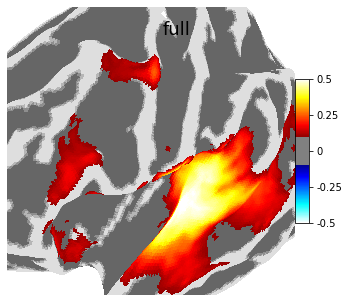

In [24]:
im = plotting.plot_surf_stat_map(
    surf_mesh=get_mesh(.5),
    stat_map=R[-1],
    hemi='left',
    view='lateral',
    vmax=.5,
    cmap='cold_hot',
    symmetric_cbar=True,
    threshold=.1,
    colorbar=True,
    title='full',
    bg_map=get_background(),
    darkness=.6,
)
ax = im.get_axes()[0]
ax.view_init(elev=10., azim=-210)
ax.dist = 4

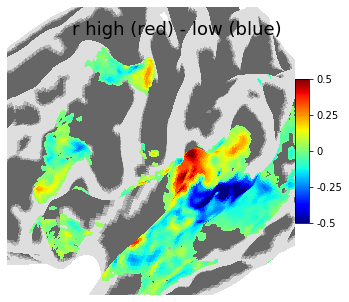

In [25]:
diff = R[1] - R[0]
diff[R[-1]<.1] = 0
im = plotting.plot_surf_stat_map(
    surf_mesh=get_mesh(.3),
    stat_map=diff,
    hemi='left',
    view='lateral',
    vmax=.5,
    cmap='jet',
    symmetric_cbar=True,
    threshold=.001,
    colorbar=True,
    title='r high (red) - low (blue)',
    bg_map=get_background(lim=40),
    darkness=.6,
)
ax = im.get_axes()[0]
ax.view_init(elev=10., azim=-200)
ax.dist = 4

<div>
<img src="attachment:Screenshot.png" width="400"/>
</div>

from 
https://www.biorxiv.org/content/10.1101/2021.07.05.447566v1.full.pdf
<div>
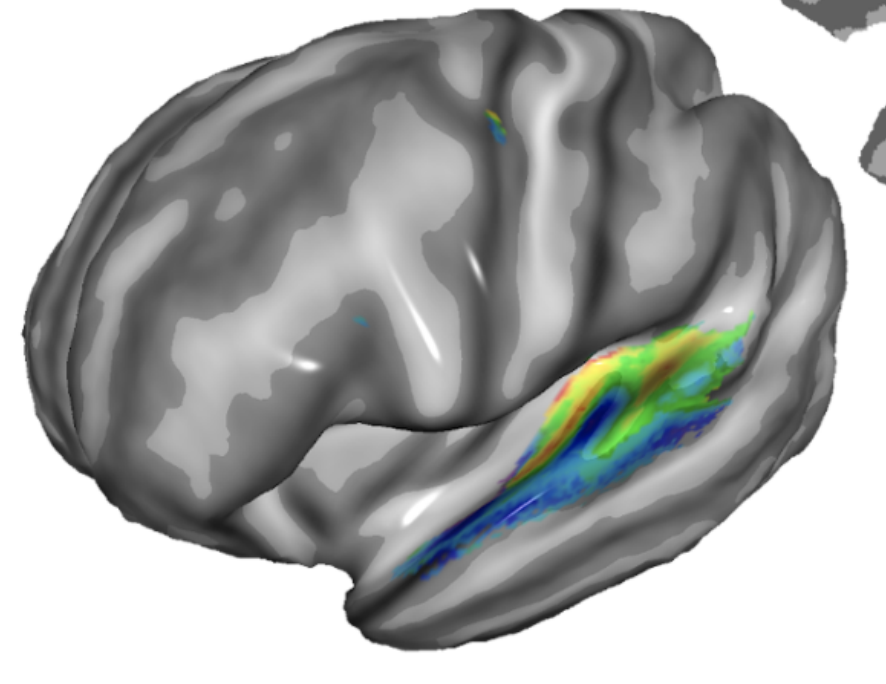
</div>


# make series of pure tones

In [26]:
def rand_log(min_value, max_value, current_value, spread):
    values = np.logspace(np.log10(min_value), 
                         np.log10(max_value), 
                         10_000)
    idx = np.where(values>=current_value)[0][0]
    idx = idx + int(np.random.randn()*spread)
    idx = min(idx, len(values)-1)
    idx = max(idx, 0)
    return values[idx]


def make_sound(tone, sfreq=22_050):
    n_tones_per_wavfile = 300
    duration = .100 # tone duration in sec
    t = np.linspace(0., 1, int(duration*sfreq))

    rate = 1.33 # Hz sound per second
    silence = .025
    enveloppe = np.sin(2. * np.pi * rate/2 * t) ** 2
    enveloppe /= enveloppe.max()
    enveloppe[-int(silence*sfreq):] = 0
    
    sounds = []
    for _ in range(n_tones_per_wavfile):
        tone_ = rand_log(10, 1e6, tone, spread=100)
        sound = np.sin(2. * np.pi * tone_ * t)
        sound *= enveloppe
        sounds.append(sound)
    sound = np.hstack(sounds)
    silence = np.zeros_like(sound)
    wav = np.hstack([silence, sound, silence])
    # add noise to avoid 0
    wav += np.random.randn(*wav.shape)*1e-7
    return wav

In [27]:
# pure tones presented at a rate of 10 per second. Each tone lasted 75 ms, with 5-ms cosine ramps
# 
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5548253/#R11

<Figure size 432x288 with 0 Axes>

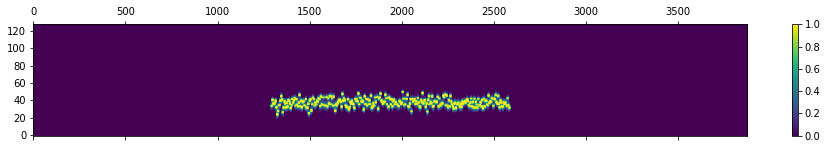

<Figure size 432x288 with 0 Axes>

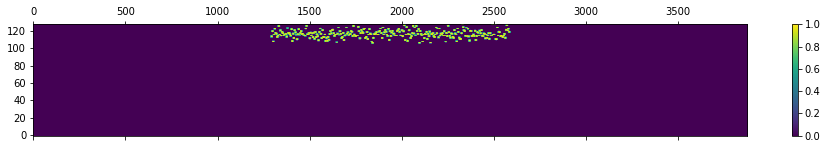

In [28]:
folder = PATHS.data / 'sounds'
folder.mkdir(exist_ok=True)
tone_file = str(folder / 'tones_%iHz.wav')

tones = (100, 800)
for tone in tones:
    file = tone_file % tone
    sound = make_sound(tone, sr) / 3.
    sf.write(file, sound, sr)
    
    plt.figure()
    wav, sr = librosa.load(tone_file % tone)

    spec = get_mel(wav, sr)
    plt.matshow(spec,  aspect='auto', vmin=0, vmax=1, origin='lower')
    plt.colorbar()

# predict tones from MEL encoder

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/129 [00:00<?, ?it/s]

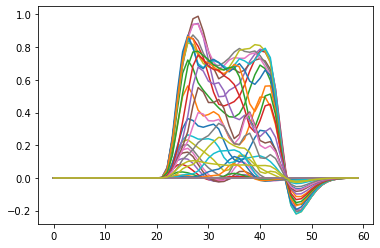

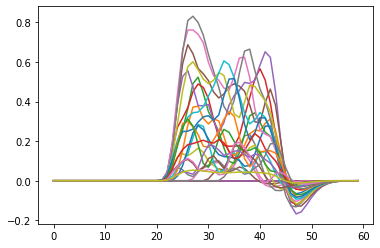

In [29]:
Y_tones = dict()
for tone in tones:
    wav, sr = librosa.load(tone_file % tone)
    assert 22050 == sr
    times, feats = get_features(wav, sr)
    plt.figure()
    plt.plot(feats.T);
    Y_tones[tone] = mapper.predict(feats.T)

### THIS IS PRECISELY THE REVERSE THAT WE EXPECT!?

In [30]:
tones

(100, 800)

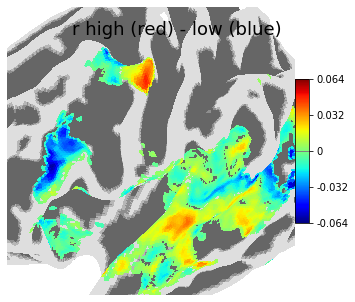

In [31]:
diff = (Y_tones[800] - Y_tones[100]).mean(0)
diff[R[-1]<.1] = 0  # FIXME
im = plotting.plot_surf_stat_map(
    surf_mesh=get_mesh(.3),
    stat_map=diff,
    hemi='left',
    view='lateral',
    #vmax=.5,
    cmap='jet',
    symmetric_cbar=True,
    threshold=.001,
    colorbar=True,
    title='r high (red) - low (blue)',
    bg_map=get_background(lim=40),
    darkness=.6,
)
ax = im.get_axes()[0]
ax.view_init(elev=10., azim=-200)
ax.dist = 4

from 
https://www.biorxiv.org/content/10.1101/2021.07.05.447566v1.full.pdf
<div>
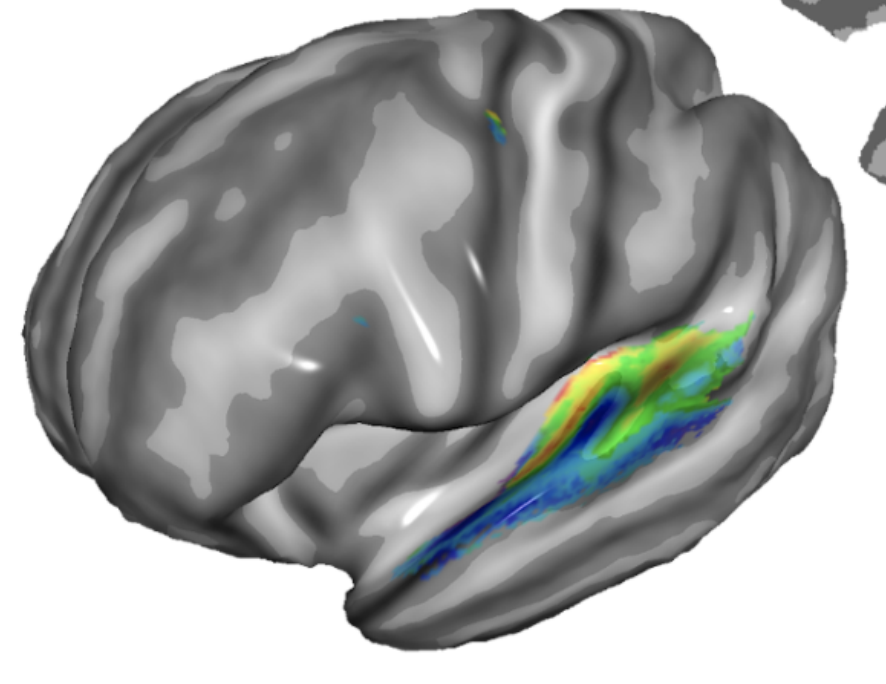
</div>

# REMOVE? extract wav2vec response to pure tones

In [73]:
def get_w2v_activations(wav_file, feature_type='tr', overwrite=False):
    # FIXME fix this file mess
    emb_file = str(wav_file).replace('.wav', f'_{feature_type}.pth')
    emb_file = PATHS.data / 'sounds' / emb_file
    
    if not emb_file.exists() or overwrite:
        print(f'Extracting activations and saving to {emb_file}...')
        for feature_type_ in ('conv', 'tr'):
            activations, _ = get_speech_activations(
                wav_file,
                model_name_or_path=f"facebook/wav2vec2-base-960h",
                feature_type="conv",  # either tr or conv
                window=5,  # stride
                context=10,  # context size
                pretrained=True,  # whether to start from scratch or use pretrained
                device="cpu",  # "cuda" if use_cuda else "cpu",
                # Preprocessing params
                TR=1.5,  # HRF
                extra_scans=10,  # HRF
                hrf_model="glover",  # HRF
                scale="minmax",
            )
            emb_file = str(wav_file).replace('.wav', f'_{feature_type}.pth')
            emb_file = PATHS.data / 'sounds' / emb_file
    
            print(f'saveing {emb_file}...')
            torch.save(activations, emb_file)
    return torch.load(emb_file)

In [36]:
missings = []
for tone in tones:
    #wav_file = folder / f'tone_{int(tone)}.wav'
    wav_file = folder / f'tones_{int(tone)}Hz.wav'
    emb_file = folder / f'tones_{int(tone)}Hz_tr.pth'
    if not emb_file.exists():
        missings.append(wav_file)

if len(missings):
    print(f'computing {len(missings)} wav2vec activations...')
    executor = AutoExecutor('./tmp')
    executor.update_parameters(slurm_array_parallelism=400, timeout_min=30)
    jobs = executor.map_array(get_w2v_activations, missings)

# Fit Narrative with real BOLD and wav2Vec embedding of sounds

In [34]:
def read_features(file, layers=[-1]):
    """retrieve and concatenate activations from wav2vec embedding file"""
    assert file.is_file(), f"{file} does not exists"
    feat = torch.load(file).numpy()
    feat = feat[list(layers)]  # [K, T, D]
    feat = np.concatenate(list(feat), axis=-1)[None]  # [1, T, K*D]
    return feat[0]

In [43]:
task = "pieman"
for task in bolds.keys():
    emb_file = PATHS.speech_embeddings / "minimal" / f"{task}_tr.pth"
    Y = bolds[task]
    X = pad(read_features(emb_file), len(Y))

missing 10 TR...
padding...
missing 9 TR...
missing 2 TR...
missing 9 TR...
missing 9 TR...
missing 9 TR...
missing 10 TR...
missing 9 TR...
missing 10 TR...
missing 1 TR...
missing 2 TR...
missing 1 TR...


In [44]:
mapper.fit(X, Y)

# wav2vec brain score

missing 10 TR...
missing 10 TR...


/private/home/jeanremi/.conda/envs/wav2vec/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  % (min_groups, self.n_splits)), UserWarning)


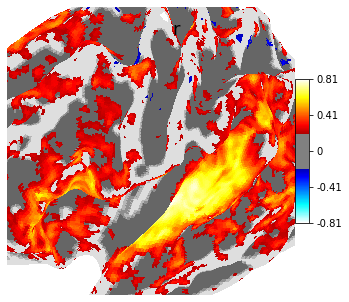

In [86]:
task = 'pieman'
Y = bolds[task]

layer_type = 'tr'
X = list()
for layer in ('conv', 'tr'):
    x = torch.load(PATHS.speech_embeddings / "minimal" / f"{task}_{layer}.pth")
    X.append(pad(np.hstack(x), len(Y)))
X = pad(np.hstack(X), len(Y))

cv = StratifiedKFold(2)
splits = np.linspace(0, 10, len(Y)).astype(int)

for train, test, in cv.split(X, splits):
    break

mapper.fit(X[train], Y[train])

r = mapper.score(X[test], Y[test])

im = plotting.plot_surf_stat_map(
    surf_mesh=get_mesh(.3),
    stat_map=r,
    hemi='left',
    view='lateral',
    #vmax=.5,
    cmap='cold_hot',
    symmetric_cbar=True,
    threshold=.2,
    colorbar=True,
    title='r',
    bg_map=get_background(lim=40),
    darkness=.6,
)
ax = im.get_axes()[0]
ax.view_init(elev=10., azim=-200)
ax.dist = 4

In [91]:
Y_pred = mapper.predict(X[test])

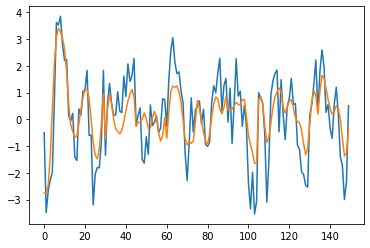

In [95]:
cherry_pick = r.argmax()
plt.plot(times, Y[test, cherry_pick])
plt.plot(times, Y_pred[:, cherry_pick])

31045

# TODO 
## low and high pass filter narrative wav files
## score corresponding effects

In [46]:
from mne.filter import filter_data
for task in tqdm(bolds.keys()):
    if (PATHS.data/'sounds'/f'{task}_high.wav').exists():
        continue
    wav, sr = librosa.load(PATHS.stimuli/f'{task}_audio.wav')
    wav = wav.astype(np.float64)
    wavs = dict()
    wavs['low'] = filter_data(wav, sr, None, 500., verbose=False)
    wavs['high'] = filter_data(wav, sr, 500., None, verbose=False)
    for k, wav in wavs.items():
        file = PATHS.data/'sounds'/f'{task}_{k}.wav'
        sf.write(file, wav.astype(np.float32), sr)

  0%|          | 0/15 [00:00<?, ?it/s]

In [74]:
# FIXME paths
missings = []
for task in tqdm(bolds.keys()):
    wav1 = PATHS.stimuli/f'{task}_audio.wav'
    wav2 = PATHS.data/'sounds'/f'{task}_high.wav'
    wav3 = PATHS.data/'sounds'/f'{task}_low.wav'

    for wav_file in (wav2, wav2, wav3):
        if ~(wav_file).exists():
            missings.append(wav_file)

if len(missings):
    print(f'computing {len(missings)} wav2vec activations...')
    executor = AutoExecutor('./tmp')
    executor.update_parameters(slurm_array_parallelism=400, timeout_min=30)
    jobs = executor.map_array(get_w2v_activations, missings)

  0%|          | 0/15 [00:00<?, ?it/s]

computing 45 wav2vec activations...


In [79]:
X = []
X_low = []
X_high = []
Y = []
splits = []
for task, bold in bolds.items():
    print('.', end='')
    n = len(bold)
    
    wav = PATHS.stimuli/f'{task}_audio.wav'
    x = get_w2v_activations(wav, layer_type)
    wav = PATHS.data/'sounds'/f'{task}_high.wav'
    x_high = get_w2v_activations(wav, layer_type)
    wav = PATHS.data/'sounds'/f'{task}_low.wav'
    x_low = get_w2v_activations(wav, layer_type)
    
    x = pad(np.hstack(x[layers]), len(bold))
    x_low = pad(np.hstack(x_low[layers]), len(bold))
    x_high = pad(np.hstack(x_high[layers]), len(bold))

    x_scaler = StandardScaler()
    x = x_scaler.fit_transform(x)
    x_low = x_scaler.transform(x_low)
    x_high = x_scaler.transform(x_high)
    
    y = Scaler().fit_transform(bold)
    s = np.arange(n)<(n//2)
    
    assert len(x) == len(y) == len(s)
    
    X.append(x)
    X_low.append(x_low)
    X_high.append(x_high)
    Y.append(y)
    splits.extend(s.tolist())
splits = np.hstack(splits) * 1.
X = np.vstack(X)
X_low = np.vstack(X_low)
X_high = np.vstack(X_high)
Y = np.vstack(Y)

.Extracting activations and saving to /datasets01/hasson_narratives/stimuli/pieman_audio_conv.pth...


KeyboardInterrupt: 

In [83]:
PATHS.speech_embeddings

PosixPath('data/speech_embeddings')

In [67]:
cv = StratifiedKFold(2)
splits = np.linspace(0, 10, len(Y)).astype(int)

for train, test, in cv.split(X, splits):
    break

mapper.fit(X[train], Y[train])

/private/home/jeanremi/.conda/envs/wav2vec/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  % (min_groups, self.n_splits)), UserWarning)


In [68]:
r = mapper.score(X[test], Y[test])
r_low = mapper.score(X_low[test], Y[test])
r_high = mapper.score(X_high[test], Y[test])

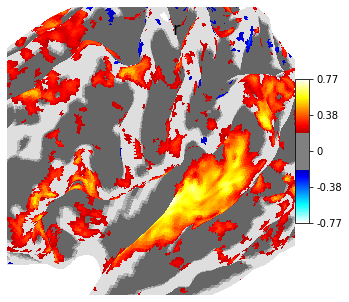

In [69]:
im = plotting.plot_surf_stat_map(
    surf_mesh=get_mesh(.3),
    stat_map=r,
    hemi='left',
    view='lateral',
    #vmax=.5,
    cmap='cold_hot',
    symmetric_cbar=True,
    threshold=.2,
    colorbar=True,
    title='r',
    bg_map=get_background(lim=40),
    darkness=.6,
)
ax = im.get_axes()[0]
ax.view_init(elev=10., azim=-200)
ax.dist = 4

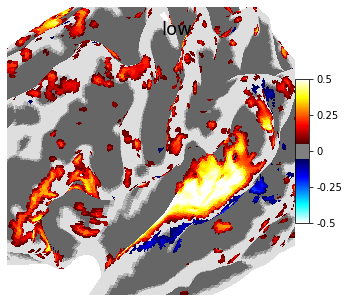

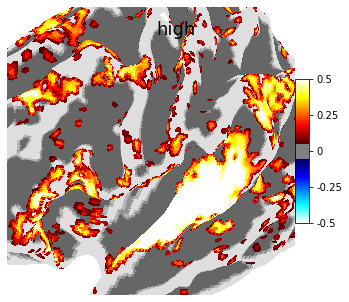

In [70]:
for cond, r_ in dict(low=r_low, high=r_high).items():
    im = plotting.plot_surf_stat_map(
        surf_mesh=get_mesh(.3),
        stat_map=r_*(r>.25),
        hemi='left',
        view='lateral',
        vmax=.5,
        cmap='cold_hot',
        symmetric_cbar=True,
        threshold=.05,
        colorbar=True,
        title=cond,
        bg_map=get_background(lim=40),
        darkness=.6,
    )
    ax = im.get_axes()[0]
    ax.view_init(elev=10., azim=-200)
    ax.dist = 4

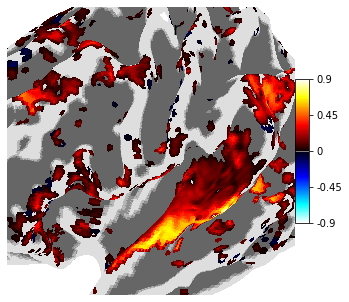

In [71]:
im = plotting.plot_surf_stat_map(
    surf_mesh=get_mesh(.3),
    stat_map=(r_high - r_low)*(r>.25),
    hemi='left',
    view='lateral',
    #vmax=.5,
    cmap='cold_hot',
    symmetric_cbar=True,
    threshold=.01,
    colorbar=True,
    title='r',
    bg_map=get_background(lim=40),
    darkness=.6,
)
ax = im.get_axes()[0]
ax.view_init(elev=10., azim=-200)
ax.dist = 4

# REMOVE? make brain predictions

In [ ]:
for k, tone in enumerate(tones):
    # read w2v respones to pure tones
    emb_file = folder / f'tones_{int(tone)}Hz.pth'
    X_star = read_features(emb_file)[:len(Y)]
    
    # init
    if k == 0:
        preds = np.zeros((len(tones), len(X_star), subj_data.shape[1]))
    
    Y_hat = mapper.predict(X_star)
    preds[k, :, valid] = Y_hat.T

In [ ]:
plt.plot(preds.mean(0)[:, ::50], lw=.5, color='k');
plt.axhline(0, color='r')

In [ ]:
# identify regions that get positively _activated_ by sounds
bsl = slice(0, 20)
stim = slice(30, 40)
mean = preds.mean(0)
activated = mean[bsl].mean(0) < mean[stim].mean(0)

In [ ]:
plt.plot(preds.mean(0)[:, activated][:, ::10]);

In [ ]:
low = np.where((tones>200) & (tones<400))[0]
mid = np.where((tones>800) & (tones<1600))[0]
high = np.where((tones>3200) & (tones<6400))[0]

low_ = preds[low, stim].mean(0).mean(0)
mid_ = preds[mid, stim].mean(0).mean(0)
high_ = preds[high, stim].mean(0).mean(0)

# m = len(tones)//2
# low_ = preds[:m, stim].mean(0).mean(0)
# high_ = preds[m:, stim].mean(0).mean(0)

diff = low_ - high_
diff[~activated] = 0

In [ ]:
for data in (diff, diff*0):
    im = plotting.plot_surf_stat_map(
        surf_mesh=get_mesh(.5),
        stat_map=data,
        hemi='left',
        view='lateral',
        #vmax=vmax,
        cmap='cold_hot',
        symmetric_cbar=True,
        threshold=1e-3,
        bg_map=get_background(),
        darkness=.5,
        colorbar=True,
        title='low-high',
        vmax=1.2,
    )
    ax = im.get_axes()[0]
    ax.view_init(elev=10., azim=-210)
    ax.dist = 5

# TODO
- [ ] loop across subjects instead of mean_bold
- [ ] simple versus complex tones (https://www.pnas.org/doi/full/10.1073/pnas.1617622114)
- [ ] speech versus other natural sounds
- [ ] unintelligible speech versus native